In [1]:
# Direct Python to plot all figures inline (i.e., not in a separate window)
%matplotlib inline

# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# Directory where NLSY79_TeachingExtract.csv file is located
data =  '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/Ec240a/Ec240a_Fall2023/Data/NLSY97/'

Econometrics_Figures_dir = '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/Ec240a/Ec240a_Fall2023/NotForRepo'

In [3]:
# Read in NLSY97 Extract
nlsy97 = pd.read_csv(data+'nlsy97ss.csv') # Reading .csv as DataFrame

# Display the first few rows of the dataframe
nlsy97.head()

,pubid,avg_earn_2014_to_2018,hgc_ever,asvab,female,black,hispanic
0,1,148921.484038,16.0,45.070,1,0,0
1,2,138251.525557,14.0,58.483,0,0,1
2,3,68974.532647,16.0,27.978,1,0,1
3,4,47482.812818,13.0,37.012,1,0,1
4,6,13759.262574,14.0,22.001,1,0,1


In [4]:
# Create sub-sample mask
sample = (nlsy97['female']==0) & (nlsy97['avg_earn_2014_to_2018']!=0) 

nlsy97 = nlsy97[sample]
nlsy97['LogEarn'] = np.log(nlsy97['avg_earn_2014_to_2018']) # Log earnings

nlsy97['hgc_X_asvab'] = nlsy97['hgc_ever']*(nlsy97['asvab'] - 50)  

nlsy97.describe()

,pubid,avg_earn_2014_to_2018,hgc_ever,asvab,female,black,hispanic,LogEarn,hgc_X_asvab
count,2807.000000,2807.000000,2807.000000,2807.000000,2807.0,2807.000000,2807.000000,2807.000000,2807.000000
mean,4437.150338,65317.899050,13.804418,46.157464,0.0,0.231920,0.195939,10.726042,-2.023654
std,2530.163541,54708.691799,3.025764,29.678535,0.0,0.422134,0.396992,1.032261,421.231705
min,2.000000,0.815382,0.000000,0.000000,0.0,0.000000,0.000000,-0.204099,-922.100000
25%,2293.500000,31025.309175,12.000000,19.506500,0.0,0.000000,0.000000,10.342559,-359.047500
50%,4379.000000,53513.941147,14.000000,43.512000,0.0,0.000000,0.000000,10.887697,-82.884000
75%,6491.000000,82273.297636,16.000000,72.281000,0.0,0.000000,0.000000,11.317802,322.620000
max,9021.000000,383978.885126,20.000000,100.000000,0.0,1.000000,1.000000,12.858343,1000.000000


In [5]:
# Short regression: OLS fit of log earnings on years of schooling
# Use White's (1980) heteroscedastic robust variance-covariance estimator
short_reg=sm.OLS(nlsy97['LogEarn'],sm.add_constant(nlsy97[['hgc_ever','black','hispanic']])).fit(cov_type='HC0')
print('------------------------------------------------------------------------------')
print('- Model SR : Short Regression                                                -')
print('------------------------------------------------------------------------------')
print('')
print(short_reg.summary())

# Long regression: OLS fit of log earnings on years of schooling & AFQT percentile
# Use White's (1980) heteroscedastic robust variance-covariance estimator
long_reg=sm.OLS(nlsy97['LogEarn'],sm.add_constant(nlsy97[['hgc_ever','asvab','black','hispanic']])).fit(cov_type='HC0')
print('------------------------------------------------------------------------------')
print('- Model LR : Long Regression                                                 -')
print('------------------------------------------------------------------------------')
print('')
print(long_reg.summary())

# Interaction regression: OLS fit of log earnings on years of schooling & AFQT percentile
# Use White's (1980) heteroscedastic robust variance-covariance estimator
inter_reg=sm.OLS(nlsy97['LogEarn'],sm.add_constant(nlsy97[['hgc_ever','hgc_X_asvab','asvab','black','hispanic']])).fit(cov_type='HC0')
print('------------------------------------------------------------------------------')
print('- Model IR : Interaction Regression                                          -')
print('------------------------------------------------------------------------------')
print('')
print(inter_reg.summary())

------------------------------------------------------------------------------
- Model SR : Short Regression                                                -
------------------------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                LogEarn   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     166.3
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           3.14e-99
Time:                        14:24:59   Log-Likelihood:                -3801.4
No. Observations:                2807   AIC:                             7611.
Df Residuals:                    2803   BIC:                             7635.
Df Model:                           3                                         
Covariance Type:                  HC0              

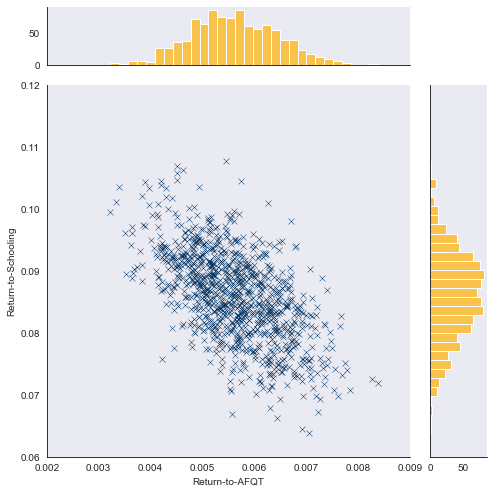

In [6]:
#-----------------------------------------------------------------------------#
#- Bayesian Bootstrap (cf., Chamberlain and Imbens (2003, JBES))             -#
#-----------------------------------------------------------------------------#

y = nlsy97['LogEarn']
X = sm.add_constant(nlsy97[['hgc_ever','asvab','black','hispanic']]) # "Permanently" add constant to design matrix

S = 1000                   # Number of posterior draws
M = np.empty((S,5))        # Matrix with posterior draws of statistics of interest
N = len(y) # Number of observations in dataset

for s in range (0,S):
    W = np.random.gamma(1.,1.,N) # Random draws of Gamma(1,1) variables
    W = W/np.sum(W)              # Converting draws to Dirichlet 
    
    result = sm.WLS(y,X,weights=W).fit()
    M[s,:] = np.matrix(result.params) # Linear regression with Dirichlet wgts
   
# Save Bayesian Bootstrap result in a dataframe
BB=pd.DataFrame({'Return-to-Schooling':M[:,1], 'Return-to-AFQT':M[:,2]})

# Scatter (use seaborn add-on to matplotlib)
sns.set_style("dark", {'axes.linewidth': 2, 'axes.edgecolor':'black'})
sns.jointplot(x="Return-to-AFQT",y="Return-to-Schooling", data=BB, kind="scatter", \
              height=7, space=0.35, color="#003262", xlim=(0.002,0.009), ylim=(0.06,0.12), marker='x',
              marginal_ticks=True, marginal_kws=dict(bins=30, fill=True, color='#FDB515', linewidth=1))

In [7]:
#-----------------------------------------------------------------------------#
#- Bayesian Bootstrap (cf., Chamberlain and Imbens (2003, JBES))             -#
#-----------------------------------------------------------------------------#

y = nlsy97['LogEarn']
X = sm.add_constant(nlsy97[['hgc_ever','hgc_X_asvab','asvab','black','hispanic']]) # "Permanently" add constant to design matrix

S = 10000                  # Number of posterior draws
M = np.empty((S,101))      # Matrix with posterior draws of statistics of interest
N = len(y)                 # Number of observations in dataset

for s in range (0,S):
    W = np.random.gamma(1.,1.,N) # Random draws of Gamma(1,1) variables
    W = W/np.sum(W)              # Converting draws to Dirichlet 
    
    result = sm.WLS(y,X,weights=W).fit()
    M[s,:] = result.params['hgc_ever']+result.params['hgc_X_asvab']*(np.array(range(0,101)) - 50) # Linear regression with Dirichlet wgts
   


In [8]:
plq = np.quantile(M, 0.05, axis=0)
puq = np.quantile(M, 0.95, axis=0)
pm = np.mean(M, axis=0)

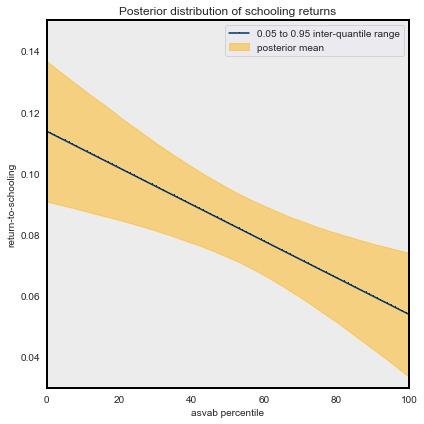

<Figure size 432x288 with 0 Axes>

In [9]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()

ax.fill_between(x=np.array(range(0,101)), y1=plq, y2=puq, color='#FDB515', alpha=0.5)
ax.plot(np.array(range(0,101)), pm, ',-', color="#003262")

ax.set_title('Posterior distribution of schooling returns')
ax.set_xlabel('asvab percentile')
ax.set_ylabel('return-to-schooling')

classes = ['0.05 to 0.95 inter-quantile range', 'posterior mean']
plt.legend(labels=classes)

plt.ylim([0.03,0.15])
plt.xlim([0,100])

# Clean up the plot, add frames etc.
ax.patch.set_facecolor('gray')               # Color of background
ax.patch.set_alpha(0.15)                     # Translucency of background
ax.grid(False)  

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('k')
    ax.spines[spine].set_linewidth(2)
    
# Save plot
plt.tight_layout()
plt.show()

plt.savefig(Econometrics_Figures_dir + '/Figure_Bayes_Bootstrap_Schooling_Returns', dpi = 500) 